In [1]:
import os, time, socket, glob

# print("【日期時間】{}".format(time.strftime("%Y/%m/%d %H:%M:%S")))
# print("【工作目錄】{}".format(os.getcwd()))
# print("【主機名稱】{} {}".format(socket.gethostname(), 
#                            socket.gethostbyname(socket.gethostname())))

# Read data

In [2]:
from python_speech_features import mfcc, delta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa

In [3]:
class WaveReader:
    def __init__(self, path, sample_rate, padding_type, read_size):
        '''
        Args:
            path: train path containing directory which one would like to load
            sample_rate: sample rate for reading .wav file
            padding_type: padding for .wav data length less than 1 second
            read_size: size that one would like to read
        '''
        
        self.path = path
        self.sample_rate = sample_rate
        self.padding_type = padding_type
        self.read_size = read_size

    def read(self, labels=None):
        '''
        read all the data under the labels(directories) one select
        
        Args:
            labels: labels(directories) one would like to load
                    None means read all the directories under that directory
        '''
        print("LABEL\tTOTAL\tREAD\tSAVED\t<1s COUNT")
        print("-----\t-----\t----\t-----\t---------")
        
        if labels is None:
            labels = [f for f in os.listdir(path) if os.path.isdir(path + "\\" + f)]
            
        elif type(labels) == str:
            samples, total_wave_count, total_wave_read, total_loss_count = self.read_dir(dir_name=labels)
            sample_labels = np.repeat(labels, total_wave_read)
            
            print("\nMISSION COMPELTE!!!")
            return samples, sample_labels, total_wave_count, total_loss_count
                    
        label_len = len(labels)
        total_wave_count = np.zeros(label_len, dtype=np.int32)
        total_wave_read = np.zeros(label_len, dtype=np.int32)
        total_loss_count = np.zeros(label_len, dtype=np.int32)

        
        for i, lab in enumerate(labels):
            samp, total_wave_count[i], total_wave_read[i], total_loss_count[i] = self.read_dir(dir_name=lab)
            
            if i == 0:
                samples = samp
                sample_labels = np.repeat(lab, total_wave_read[i])
            else:
                samples = np.concatenate((samples, samp), axis=0)
                sample_labels = np.concatenate((sample_labels, np.repeat(lab, total_wave_read[i])), axis=None)
        
        print("\nMISSION COMPELTE!!!")
        return samples, sample_labels, total_wave_count, total_loss_count
    
    def read_dir(self, dir_name):
        '''
        read one directory of given directory name
        
        Args:
            dir_name: directory name
        '''
        dir_path = os.path.join(self.path, dir_name)
        wave_files = [f for f in os.listdir(dir_path) if f.endswith('.wav')]
        total_wave_files = len(wave_files)

        if self.read_size is not None:
            wave_files_read = self.read_size
        else:
            wave_files_read = total_wave_files

        samples = np.zeros((wave_files_read, self.sample_rate))
        less_than_1s_count = 0
        num_of_file_read = 0
        for i, wav_file in enumerate(wave_files):
            wave_file_path = os.path.join(dir_path, wav_file)
            samp, _ = librosa.load(wave_file_path, sr=self.sample_rate)

            pad_size = self.sample_rate - len(samp)
            if pad_size > 0:
                less_than_1s_count += 1
                if self.padding_type is None:
                    # None: than skip this wave file
                    continue

                elif self.padding_type == "white_noise":
                    # white_noise: pad white noise data behind
                    padding = np.random.normal(0, 0.02, pad_size)
                    samples[num_of_file_read, :] = np.concatenate((samp, padding), axis=None)
                    num_of_file_read += 1


                elif self.padding_type == "zero":
                    # zero: pad zeros behind
                    padding = np.zeros(pad_size)
                    samples[num_of_file_read, :] = np.concatenate((samp, padding), axis=None)
                    num_of_file_read += 1
            else:
                samples[num_of_file_read, :] = samp
                num_of_file_read += 1

            print("{}\t{}\t{}\t{}\t{}".format(dir_name, 
                                              total_wave_files, 
                                              i+1, 
                                              num_of_file_read, 
                                              less_than_1s_count), end="\r")
            
            if num_of_file_read == wave_files_read:
                break
                
        print()

        return samples, total_wave_files, wave_files_read, less_than_1s_count

In [4]:
SAMPLE_RATE = 16000

train_audio_path = os.path.join(os.path.dirname(os.getcwd()), "data", "train", "audio")
phoneme_path = os.path.join(os.getcwd(), "Phonemes")
phoneme_dataframe = pd.read_csv(os.path.join(phoneme_path, "phonemes.csv"))

reader = WaveReader(path=train_audio_path, 
                    sample_rate=SAMPLE_RATE, 
                    padding_type=None, 
                    read_size=2000)

wav_array, label_array, total, loss = reader.read(labels=phoneme_dataframe.words)

print()
print(f"NaN Number: {np.sum(np.isnan(wav_array))}")
print(f"Inf Number: {np.sum(np.isinf(wav_array))}")

LABEL	TOTAL	READ	SAVED	<1s COUNT
-----	-----	----	-----	---------
zero	2376	2160	2000	160
one	2370	2262	2000	262
two	2373	2222	2000	222
three	2356	2207	2000	207
four	2372	2201	2000	201
five	2357	2185	2000	185
six	2369	2164	2000	164
seven	2377	2194	2000	194
eight	2352	2232	2000	232
nine	2364	2178	2000	178

MISSION COMPELTE!!!

NaN Number: 0
Inf Number: 0


In [5]:
def apply_mfcc(inputs, sample_rate):
    input_length = len(inputs)
    sample_shape = mfcc(inputs[0], sample_rate, appendEnergy=True).shape
    outputs = np.zeros(((input_length, sample_shape[0], sample_shape[1]*3)))
    print(f"Outputs Shape: (input size, time step, featured) {outputs.shape}\n")
    
    for i in range(input_length):
        print(f"Applying MFCC transformation to {i+1}th wave array", end="\r")
        mfcc_feat = mfcc(inputs[i, :], sample_rate, appendEnergy=True).T

        d_mfcc_feat = delta(mfcc_feat, 2)
        mfcc_features = np.concatenate((mfcc_feat.T, d_mfcc_feat.T), axis=1)
        
        dd_mfcc_feat = delta(d_mfcc_feat, 2)
        mfcc_features = np.concatenate((mfcc_features, dd_mfcc_feat.T), axis=1)
        
        outputs[i, :, :] = mfcc_features
        
    print("\n\nMISSION COMPELTE!!!")
    return outputs

In [6]:
mfcc_wav_array = apply_mfcc(wav_array, sample_rate=SAMPLE_RATE)

Outputs Shape: (input size, time step, featured) (20000, 99, 39)

Applying MFCC transformation to 20000th wave array

MISSION COMPELTE!!!


In [7]:
shape = mfcc_wav_array.shape
flattened_wav_array = mfcc_wav_array.reshape(-1, shape[1]*shape[2])
print(f"Flattened MFCC Wave Shape: {flattened_wav_array.shape}")

Flattened MFCC Wave Shape: (20000, 3861)


# Preprocess

In [9]:
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC

from scikitplot.metrics import plot_confusion_matrix

train_x, test_x, train_y, test_y = train_test_split(flattened_wav_array, label_array, test_size = 0.2)

  Using cached scikit_plot-0.3.7-py3-none-any.whl (33 kB)


### PCA

In [29]:
pca = PCA(n_components = .945).fit(train_x)
pca_train = pca.transform(train_x)
pca_test = pca.transform(test_x)

print(f"PCA Output Shape: {pca_train.shape}")

PCA Output Shape: (16000, 348)


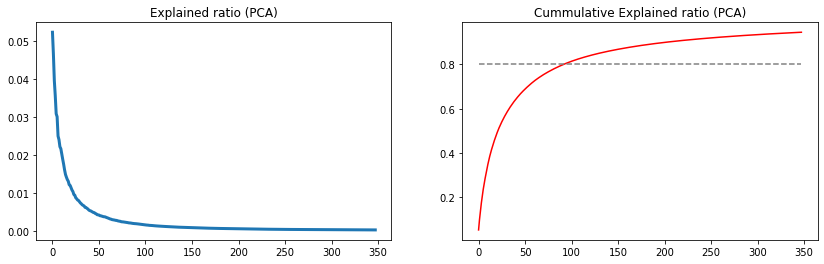

In [30]:
x = range(pca.n_components_)
y = pca.explained_variance_ratio_

plt.figure(figsize = (14, 4))
plt.subplot(1, 2, 1)
plt.plot(x, y, linewidth=3)
plt.title("Explained ratio (PCA)")

plt.subplot(1, 2, 2)
plt.plot(x, np.cumsum(y), color="red")
plt.plot(x, np.repeat(0.8, len(x)), color="gray", linestyle="--")
plt.title("Cummulative Explained ratio (PCA)")

plt.show()

# Classification

### PCA + LDA

In [35]:
print(f"Input Shape:  {pca_train.shape}")
print(f"Target Shape: {train_y.shape}")

Input Shape:  (16000, 348)
Target Shape: (16000,)


In [32]:
lda = LDA(n_components=9).fit(pca_train, train_y)
lda_train = lda.transform(pca_train)
lda_test = lda.transform(pca_test)

lda_pred = lda.predict(pca_test)
lda_acc = metrics.accuracy_score(test_y, lda_pred)
print("LDA Accuracy: {:.2f}%".format(lda_acc*100))

LDA Accuracy: 61.38%


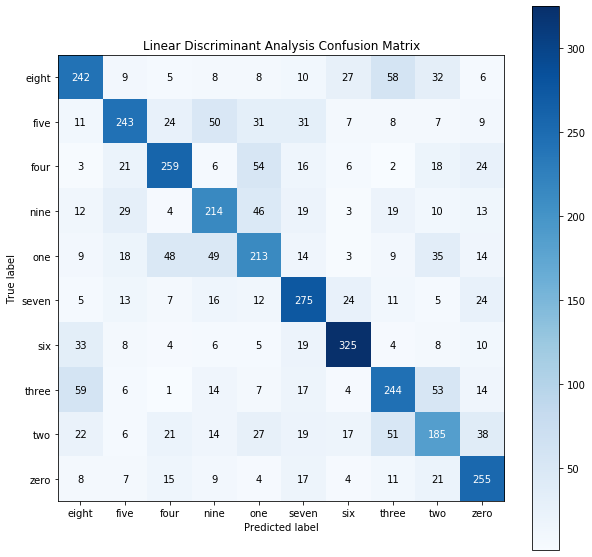

In [33]:
plot_confusion_matrix(y_true=lda_pred, 
                      y_pred=test_y, 
                      labels=None, 
                      true_labels=None, 
                      pred_labels=None, 
                      title="Linear Discriminant Analysis Confusion Matrix", 
                      normalize=False, 
                      hide_zeros=False, 
                      hide_counts=False, 
                      x_tick_rotation=0, 
                      ax=None, 
                      figsize=(10, 10), 
                      cmap='Blues', 
                      title_fontsize='large', 
                      text_fontsize='medium')

### PCA + KNN

In [38]:
# PCA KNN model
for i in range(1, 11):
    knn = KNN(n_neighbors=i).fit(pca_train, train_y)

    # 預測
    knn_pred = knn.predict(pca_test)

    # 績效
    knn_acc = metrics.accuracy_score(test_y, knn_pred)
    print("KNN k = {} Accuracy: {:.2f}%".format(i, knn_acc*100))

KNN k = 1 Accuracy: 79.62%
KNN k = 2 Accuracy: 75.28%
KNN k = 3 Accuracy: 80.00%
KNN k = 4 Accuracy: 80.55%
KNN k = 5 Accuracy: 81.97%
KNN k = 6 Accuracy: 82.03%
KNN k = 7 Accuracy: 82.65%
KNN k = 8 Accuracy: 82.83%
KNN k = 9 Accuracy: 83.30%
KNN k = 10 Accuracy: 83.53%


In [39]:
# LDA KNN model
for i in range(1, 11):
    knn = KNN(n_neighbors=i).fit(lda_train, train_y)

    # 預測
    knn_pred = knn.predict(lda_test)

    # 績效
    knn_acc = metrics.accuracy_score(test_y, knn_pred)
    print("KNN k = {} Accuracy: {:.2f}%".format(i, knn_acc*100))

KNN k = 1 Accuracy: 52.65%
KNN k = 2 Accuracy: 51.42%
KNN k = 3 Accuracy: 55.17%
KNN k = 4 Accuracy: 57.07%
KNN k = 5 Accuracy: 58.30%
KNN k = 6 Accuracy: 59.35%
KNN k = 7 Accuracy: 60.60%
KNN k = 8 Accuracy: 60.62%
KNN k = 9 Accuracy: 60.68%
KNN k = 10 Accuracy: 61.35%


In [40]:
# 建立 knn 模型
knn = KNN(n_neighbors=8).fit(pca_train, train_y)

# 預測
knn_pred = knn.predict(pca_test)

# 績效
knn_acc = metrics.accuracy_score(test_y, knn_pred)
print("KNN Accuracy: {:.2f}%".format(knn_acc*100))

KNN Accuracy: 82.83%


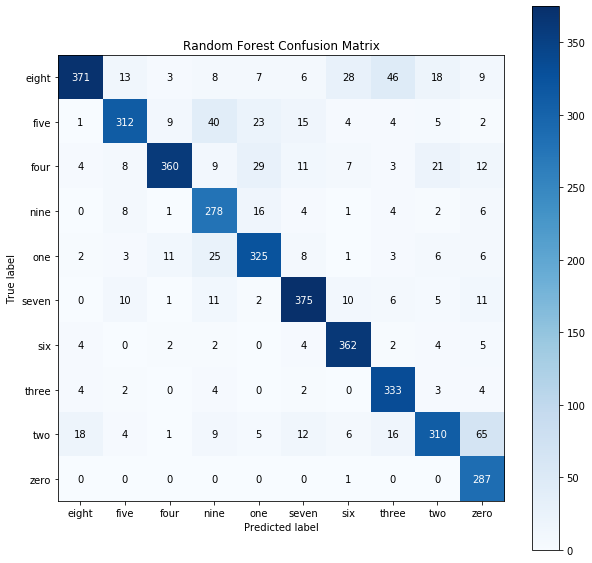

In [41]:
plot_confusion_matrix(y_true=knn_pred, 
                      y_pred=test_y, 
                      labels=None, 
                      true_labels=None, 
                      pred_labels=None, 
                      title="Random Forest Confusion Matrix", 
                      normalize=False, 
                      hide_zeros=False, 
                      hide_counts=False, 
                      x_tick_rotation=0, 
                      ax=None, 
                      figsize=(10, 10), 
                      cmap='Blues', 
                      title_fontsize='large', 
                      text_fontsize='medium')

### PCA + Random Forest

In [42]:
# 建立 random forest 模型
rf = RF(n_estimators = 180).fit(pca_train, train_y)

# 預測
rf_pred = rf.predict(pca_test)

# 績效
rf_acc = metrics.accuracy_score(test_y, rf_pred)
print("Random Forest Accuracy: {:.2f}%".format(rf_acc*100))

Random Forest Accuracy: 72.38%


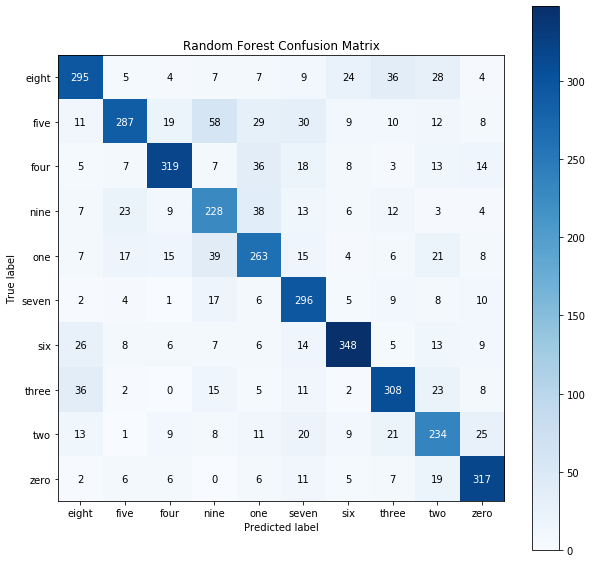

In [43]:
plot_confusion_matrix(y_true=rf_pred, 
                      y_pred=test_y, 
                      labels=None, 
                      true_labels=None, 
                      pred_labels=None, 
                      title="Random Forest Confusion Matrix", 
                      normalize=False, 
                      hide_zeros=False, 
                      hide_counts=False, 
                      x_tick_rotation=0, 
                      ax=None, 
                      figsize=(10, 10), 
                      cmap='Blues', 
                      title_fontsize='large', 
                      text_fontsize='medium')

### PCA + SVM

In [44]:
svm = SVC().fit(pca_train, train_y)
svm_pred = svm.predict(pca_test)

svm_acc = metrics.accuracy_score(test_y, svm_pred)
print("SVM Accuracy: {:.2f}%".format(svm_acc*100))

SVM Accuracy: 86.55%


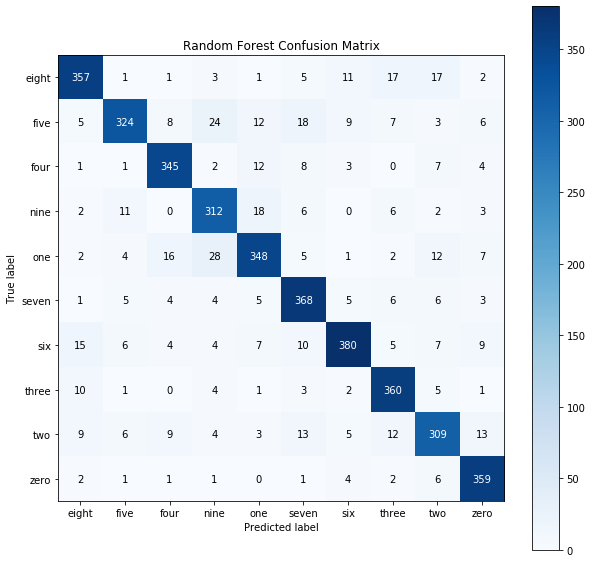

In [45]:
plot_confusion_matrix(y_true=svm_pred, 
                      y_pred=test_y, 
                      labels=None, 
                      true_labels=None, 
                      pred_labels=None, 
                      title="Random Forest Confusion Matrix", 
                      normalize=False, 
                      hide_zeros=False, 
                      hide_counts=False, 
                      x_tick_rotation=0, 
                      ax=None, 
                      figsize=(10, 10), 
                      cmap='Blues', 
                      title_fontsize='large', 
                      text_fontsize='medium')

### MLP

In [10]:
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
print(f"Tensorflow Version: {tf.__version__}")
print()
print(f"GPU available: {tf.test.is_gpu_available()}")
print(f"CUDA enabled: {tf.test.is_built_with_cuda()}")

Tensorflow Version: 2.0.0

GPU available: True
CUDA enabled: True


In [16]:
BATCH_SIZE = 1
EPOCHS = 10

data_shape = mfcc_wav_array.shape
input_shape = (data_shape[1], data_shape[2])

print(f"Input Shape: (input size, time step, features) {data_shape}")
print(f"Input Layer: (batch size, time step, features) {input_shape}")

Input Shape: (input size, time step, features) (20000, 99, 39)
Input Layer: (batch size, time step, features) (99, 39)


In [17]:
le = LabelEncoder().fit(phoneme_dataframe.words)
print(f"Labels: {le.classes_}")

targets = le.transform(label_array)
train_x, test_x, train_y, test_y = train_test_split(mfcc_wav_array, targets, test_size = 0.2, shuffle=True)

Labels: ['eight' 'five' 'four' 'nine' 'one' 'seven' 'six' 'three' 'two' 'zero']


In [18]:
# define model
model = tf.keras.Sequential([
    # input layer
    tf.keras.layers.InputLayer(input_shape=input_shape, batch_size=1),
    
    # conv1d layer
    tf.keras.layers.Conv1D(filters=64, padding="same", kernel_size=3, activation="relu"),     
    tf.keras.layers.MaxPooling1D(pool_size=3), 
    tf.keras.layers.BatchNormalization(),
    
    # conv1d layer
    tf.keras.layers.Conv1D(filters=128, padding="same", kernel_size=3, activation='relu'), 
    tf.keras.layers.MaxPooling1D(pool_size=3), 
    
    # Flatten layer
    tf.keras.layers.Flatten(),
    
    # output layer
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dense(10, activation="softmax")    
])

In [19]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer = 'adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (1, 99, 64)               7552      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (1, 33, 64)               0         
_________________________________________________________________
batch_normalization_1 (Batch (1, 33, 64)               256       
_________________________________________________________________
conv1d_3 (Conv1D)            (1, 33, 128)              24704     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (1, 11, 128)              0         
_________________________________________________________________
flatten_1 (Flatten)          (1, 1408)                 0         
_________________________________________________________________
dense_2 (Dense)              (1, 128)                 

In [21]:
history = model.fit(train_x, train_y, 
                    epochs=EPOCHS, 
                    validation_data=(test_x, test_y), 
                    shuffle=True)

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 64s 4ms/sample - loss: 0.4717 - accuracy: 0.8499 - val_loss: 1.0914 - val_accuracy: 0.7812
Epoch 2/10
16000/16000 [==============================] - 63s 4ms/sample - loss: 0.2543 - accuracy: 0.9251 - val_loss: 0.7230 - val_accuracy: 0.8422
Epoch 3/10
16000/16000 [==============================] - 63s 4ms/sample - loss: 0.1928 - accuracy: 0.9433 - val_loss: 0.7018 - val_accuracy: 0.8800
Epoch 4/10
16000/16000 [==============================] - 61s 4ms/sample - loss: 0.1652 - accuracy: 0.9513 - val_loss: 0.6980 - val_accuracy: 0.8800
Epoch 5/10
16000/16000 [==============================] - 64s 4ms/sample - loss: 0.1528 - accuracy: 0.9571 - val_loss: 0.8449 - val_accuracy: 0.8760
Epoch 6/10
16000/16000 [==============================] - 63s 4ms/sample - loss: 0.1242 - accuracy: 0.9642 - val_loss: 0.8985 - val_accuracy: 0.8810
Epoch 7/10
16000/16000 [==============================] -

In [22]:
def AccLossPlot(TrainHistory):    
    acc = TrainHistory.history['accuracy']
    val_acc = TrainHistory.history['val_accuracy']

    loss = TrainHistory.history['loss']
    val_loss = TrainHistory.history['val_loss']

    epochs_range = range(EPOCHS)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

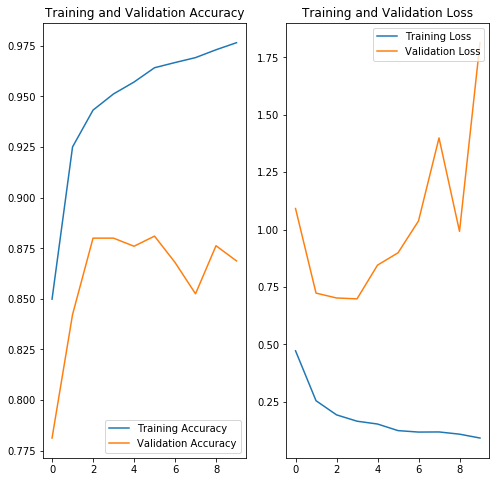

In [23]:
AccLossPlot(history)

In [24]:
DROPOUT_RATIO = 0.2
model = tf.keras.Sequential([
    # input layer
    tf.keras.layers.InputLayer(input_shape=input_shape, batch_size=1),
    
    # conv1d layer
    tf.keras.layers.Conv1D(filters=64, padding="same", kernel_size=3, activation="relu"),     
    tf.keras.layers.MaxPooling1D(pool_size=3), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(DROPOUT_RATIO),
    
    # conv1d layer
    tf.keras.layers.Conv1D(filters=128, padding="same", kernel_size=3, activation='relu'), 
    tf.keras.layers.MaxPooling1D(pool_size=3), 
    
    # BLSTM layer
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)), 
    tf.keras.layers.Flatten(),
    
    # output layer
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dropout(DROPOUT_RATIO),
    tf.keras.layers.Dense(10, activation="softmax")    
])

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer = 'adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (1, 99, 64)               7552      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (1, 33, 64)               0         
_________________________________________________________________
batch_normalization_2 (Batch (1, 33, 64)               256       
_________________________________________________________________
dropout (Dropout)            (1, 33, 64)               0         
_________________________________________________________________
conv1d_5 (Conv1D)            (1, 33, 128)              24704     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (1, 11, 128)              0         
_________________________________________________________________
flatten_2 (Flatten)          (1, 1408)                

In [25]:
history = model.fit(train_x, train_y, 
                    epochs=EPOCHS, 
                    validation_data=(test_x,  test_y), 
                    shuffle=True)

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 64s 4ms/sample - loss: 0.9206 - accuracy: 0.6878 - val_loss: 0.8206 - val_accuracy: 0.8210
Epoch 2/10
16000/16000 [==============================] - 63s 4ms/sample - loss: 0.3399 - accuracy: 0.8979 - val_loss: 0.7624 - val_accuracy: 0.8367
Epoch 3/10
16000/16000 [==============================] - 63s 4ms/sample - loss: 0.2779 - accuracy: 0.9193 - val_loss: 0.7430 - val_accuracy: 0.8265
Epoch 4/10
16000/16000 [==============================] - 63s 4ms/sample - loss: 0.2476 - accuracy: 0.9299 - val_loss: 0.6098 - val_accuracy: 0.8708
Epoch 5/10
16000/16000 [==============================] - 62s 4ms/sample - loss: 0.2356 - accuracy: 0.9323 - val_loss: 0.9529 - val_accuracy: 0.8585
Epoch 6/10
16000/16000 [==============================] - 67s 4ms/sample - loss: 0.2184 - accuracy: 0.9374 - val_loss: 0.7213 - val_accuracy: 0.8683
Epoch 7/10
16000/16000 [==============================] -

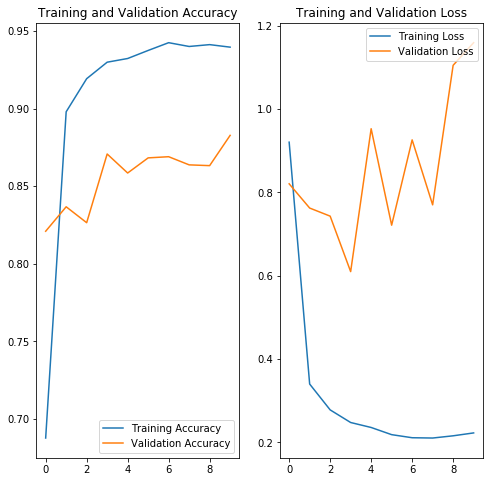

In [26]:
AccLossPlot(history)

In [28]:
model = tf.keras.Sequential([
    # input layer
    tf.keras.layers.InputLayer(input_shape=input_shape, batch_size=1),
    
    # conv1d layer
    tf.keras.layers.Conv1D(filters=64, padding="same", kernel_size=3, activation="relu"),     
    tf.keras.layers.MaxPooling1D(pool_size=3), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(DROPOUT_RATIO),
    
    # conv1d layer
    tf.keras.layers.Conv1D(filters=128, padding="same", kernel_size=3, activation='relu'), 
    tf.keras.layers.MaxPooling1D(pool_size=3), 
    
    # BLSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)), 
    
    # Flatten
    tf.keras.layers.Flatten(),
    
    # output layer
    tf.keras.layers.Dense(256, activation='relu'), 
    tf.keras.layers.Dropout(DROPOUT_RATIO),
    tf.keras.layers.Dense(10, activation="softmax")    
])

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer = 'adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (1, 99, 64)               7552      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (1, 33, 64)               0         
_________________________________________________________________
batch_normalization_4 (Batch (1, 33, 64)               256       
_________________________________________________________________
dropout_4 (Dropout)          (1, 33, 64)               0         
_________________________________________________________________
conv1d_9 (Conv1D)            (1, 33, 128)              24704     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (1, 11, 128)              0         
_________________________________________________________________
bidirectional_1 (Bidirection (1, 11, 256)             

In [29]:
history = model.fit(train_x, train_y, 
                    epochs=EPOCHS, 
                    validation_data=(test_x,  test_y), 
                    shuffle=True)

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 134s 8ms/sample - loss: 0.5813 - accuracy: 0.8153 - val_loss: 1.0615 - val_accuracy: 0.7625
Epoch 2/10
16000/16000 [==============================] - 132s 8ms/sample - loss: 0.3966 - accuracy: 0.8838 - val_loss: 0.9092 - val_accuracy: 0.8100
Epoch 3/10
16000/16000 [==============================] - 132s 8ms/sample - loss: 0.3538 - accuracy: 0.9018 - val_loss: 1.0505 - val_accuracy: 0.7935
Epoch 4/10
16000/16000 [==============================] - 131s 8ms/sample - loss: 0.3491 - accuracy: 0.9055 - val_loss: 1.3280 - val_accuracy: 0.7972
Epoch 5/10
16000/16000 [==============================] - 136s 8ms/sample - loss: 0.3448 - accuracy: 0.9060 - val_loss: 1.4806 - val_accuracy: 0.8213
Epoch 6/10
16000/16000 [==============================] - 132s 8ms/sample - loss: 0.3525 - accuracy: 0.9057 - val_loss: 1.8951 - val_accuracy: 0.7983
Epoch 7/10
16000/16000 [===========================

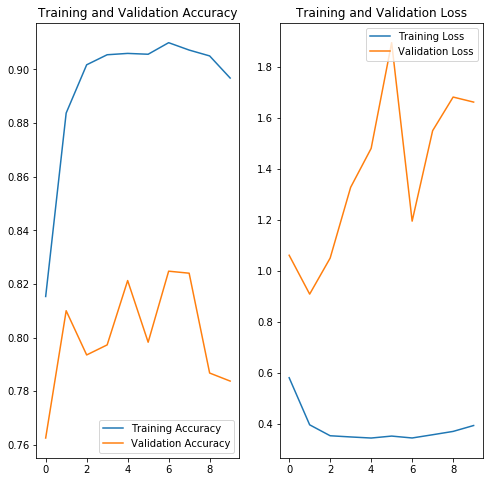

In [30]:
AccLossPlot(history)

In [49]:
model = tf.keras.Sequential([
    # input layer
    tf.keras.layers.InputLayer(input_shape=input_shape, batch_size=1),
    
    # LSTM
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dropout(DROPOUT_RATIO),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(256, activation="softmax"),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer = 'adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (1, 99, 32)               9216      
_________________________________________________________________
dropout_17 (Dropout)         (1, 99, 32)               0         
_________________________________________________________________
flatten_14 (Flatten)         (1, 3168)                 0         
_________________________________________________________________
dense_28 (Dense)             (1, 256)                  811264    
_________________________________________________________________
dense_29 (Dense)             (1, 10)                   2570      
Total params: 823,050
Trainable params: 823,050
Non-trainable params: 0
_________________________________________________________________


In [50]:
history = model.fit(train_x, train_y, 
                    epochs=EPOCHS, 
                    validation_data=(test_x,  test_y), 
                    shuffle=True)

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 117s 7ms/sample - loss: 1.7097 - accuracy: 0.3761 - val_loss: 1.4451 - val_accuracy: 0.4577
Epoch 2/10
 9916/16000 [=================>............] - ETA: 38s - loss: 1.3272 - accuracy: 0.4894

KeyboardInterrupt: 